<a href="https://colab.research.google.com/github/mneunhoe/ds3_ml/blob/main/01_ds3_ml_logit_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{DS}^3$: Introduction to Machine Learning
(Marcel Neunhoeffer, LMU Munich)

This is the first workbook for the Data Science Summer School course "Introduction to Machine Learning". 

You can find the slides and the following workbooks for this course at: https://github.com/mneunhoe/ds3_ml


In this workbook we will implement a first Machine Learning model from scratch: Logistic regression or short logit. Along the way we will learn a lot about important basics in Machine Learning.



Before we get started, we install and load some helpful packages to our R environment.

In [10]:
p_needed <- c("viridis", "skimr")
packages <- rownames(installed.packages())
p_to_install <- p_needed[!(p_needed %in% packages)]
if (length(p_to_install) > 0) {
  install.packages(p_to_install)
}
sapply(p_needed, require, character.only = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: skimr



viridis   skimr 
   TRUE    TRUE

## Logit from Scratch


### Setting up some toydata

First, we generate some simple toy data.

── Data Summary ────────────────────────
                           Values 
Name                       toydata
Number of rows             10000  
Number of columns          3      
_______________________           
Column type frequency:            
  numeric                  3      
________________________          
Group variables            None   

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable n_missing complete_rate     mean    sd    p0    p25      p50
1 y                     0             1  0.499   0.500  0     0      0      
2 x1                    0             1 -0.00683 1.00  -3.84 -0.675 -0.00411
3 x2                    0             1 -0.00713 0.994 -4.02 -0.685  0.00394
    p75  p100 hist 
1 1      1    ▇▁▁▁▇
2 0.656  4.02 ▁▃▇▂▁
3 0.657  4.19 ▁▃▇▂▁


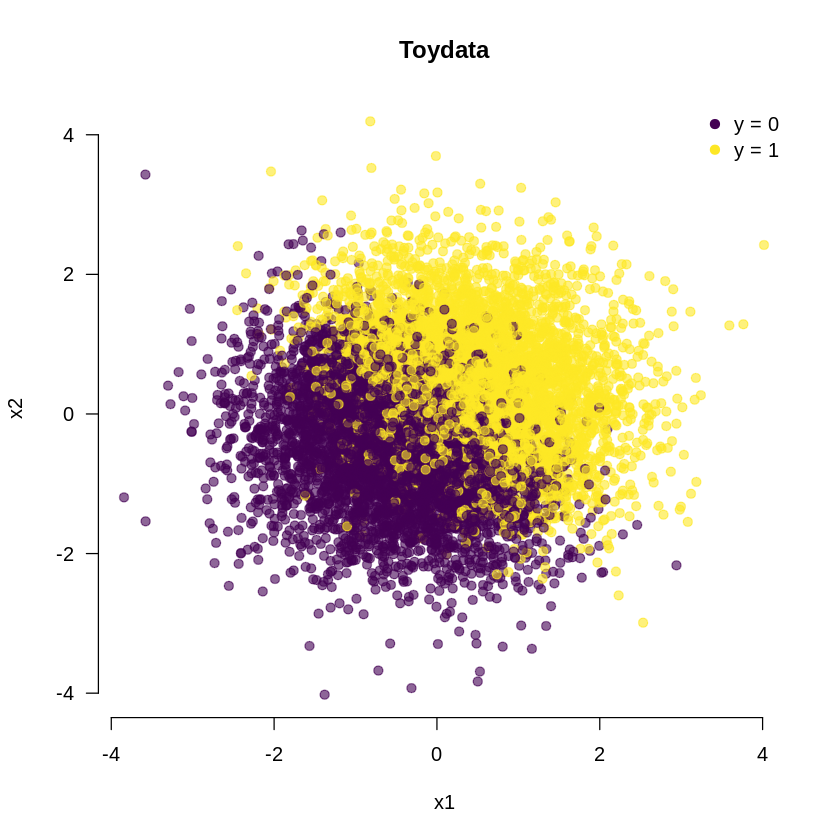

In [72]:
# We setup some toy data where we know the true data generating process.

# Using a seed we will all get the same "random" data
set.seed(210728)

# The true coefficients
beta <- c(0, 2, 2)

# The values of X1 and X2 come from standard normal distributions
X <- cbind(1, rnorm(10000), rnorm(10000))

# To get the associated labels y, we first calculate the linear predictor
h <- X %*% beta

# Transform it to probabilities (using the sigmoid function)

# We will need the sigmoid function again.
sigmoid <- function(x) {
  1/(1+exp(-x))
}

# Now z contains probabilities
z <- sigmoid(h)

# And we can draw the values of the label y from a binomial distribution with 
# the probabilities z
y <- rbinom(10000, 1, z)

# Putting together y, x1 and x2 in a typical dataframe
toydata <- data.frame(y = y, x1 = X[,2], x2 = X[,3])

# Get an overview of the dataset

# With a skim summary
skimr::skim(toydata)

# With a simple scatterplot
plot(toydata$x1, toydata$x2,
      main = "Toydata", xlab = "x1", ylab = "x2", las = 1,
      col = viridis::viridis(2, 0.6)[toydata$y+1], 
      pch = 19, bty = "n")
legend("topright", legend = c("y = 0", "y = 1"), 
        pch = 19, col = viridis::viridis(2), bty = "n")

### Training Set and Test Set
Before we get started we split our dataset into a training set and a test set. We will train our machine learning model using the train set and then evaluate its performance on the test set. It is important that the test set is never touched during training. Otherwise you can get a biased performance evaluation.

Here we take 80% of the data and use it in the training set. We put the remaining 20% in the test set.


In [76]:
train_sel <- sample(nrow(toydata), 0.8 * nrow(toydata))

training_set <- toydata[train_sel, ]
test_set <- toydata[-train_sel,]

,y,x1,x2
,<int>,<dbl>,<dbl>
6193,1,0.4881530,-1.2780867
656,0,-0.0172578,0.3149478
7938,0,-0.7604729,0.4090668
1525,0,-0.7025687,1.0280397
339,0,-1.9674124,0.1703866
3387,0,-0.3382897,-1.2202195


### Defining the model and cost function 

We want to predict the labels based on x1 and x2. Given the data we now can define a suitable model. 

For logistic regression we assume the following model:
$p_{model}(y|\mathbf{x})=\mathcal{B}(y; \frac{1}{1+e^{-\mathbf{x}\beta}})$

Based on the model we can derive an appropriate cost function (denoted by $J$) using the negative log-likelihood (NLL). So minimizing the cost function corresponds to maximizing the log-likelihood (and likelihood). 

Digression: In Machine Learning, you will often hear the terms loss function and cost function. Typically, a loss function is defined on a single data example (one observation), whereas a cost function is more general and usually the sum or mean of individual losses. 

So in the context of the logit model the cost function is: $J(\beta) = -\mathbb{E} \log p_{model}(y|\mathbf{x})$. Where $\log p_{model}(y|\mathbf{x})$ is the log-likelihood, i.e. for the logit model: $y\log \frac{1}{1+e^{-\mathbf{x}\beta}} + (1-y) \log (1 - \frac{1}{1+e^{-\mathbf{x}\beta}})$.

Let's put the cost function into R so that we can work with it.



In [20]:
cost_fct <- function(y, pred) {
 - mean(y * log(pred) + (1 - y) * log(1 - pred))
}

### Defining the optimization procedure: Gradient Descent

We want to minimize the cost function. That means given our data we want to find the coefficients $\beta$ that give us the lowest value of the cost function. One way to find the minimum of a function is to use gradient descent. 

In simple terms this proceeds as follows. We start at some values for all coefficients evaluate the function in the immediate neighborhood of the current values and then take a step "downhill". After the step we update the coefficients to the spot where we arrived at. And do the same thing again. 

To figure out what the environment of the function looks like we need to calculate the gradient (similar to the first derivative of a one-dimensional function) of the cost function w.r.t. to the coefficients $\beta$. 

$\nabla_{\beta}J(\beta) = \frac{1}{m}\sum_1^m (\frac{1}{1+e^{-\mathbf{x^{(i)}}\beta}}- y^{(i)})\mathbf{x}^{(i)}$.

(This can be calculated using the chain rule. If you want to learn more about it, join the Deep Learning course tomorrow. This is the backbone of deep learning!)


In [29]:
grad_fct <- function(X, pred, y){
  1/nrow(X) * t(X) %*% (pred - y)
}

Since we need predictions in both the calculation of the loss and the gradient, it is useful to have a function to do that for us.

In [30]:
prediction_fct <- function(X, beta) {
  h <- X %*% beta
  z <- sigmoid(h)
  return(z)
}

Let's see what the cost is if we start at $\beta^0 = (0, 0, 0)$.

In [31]:
beta_hat <- c(0, 0, 0)
cost_fct(y, prediction_fct(X, beta_hat))

[1] 0.6931472

And now we can take a step downhill. The only thing we still need to set is the stepsize ($\alpha$), i.e. how long should the step in the direction of the negative gradient (downhill) be? This is also called the learning rate. And this is our first hyperparameter we get to know.

Formally, a step is $\beta^i = \beta^{i-1} - \alpha \nabla_\beta^{i-1} J(\beta^{i-1})$.

In [37]:
grad_step <- function(beta_hat, alpha = 0.1, X, y) {
  beta_hat - alpha * grad_fct(X, prediction_fct(X, beta_hat), y)
}

beta_hat <- grad_step(beta_hat, alpha = 0.1, X, y)

cat(beta_hat)

-0.0011 0.02713155 0.023365

These are our new values of $\beta$. And now we want to repeat this until we are close to the minimum of the cost function. Let's see how far we get when we take 100 steps with $\alpha = 1$.

In [100]:
train_X <- as.matrix(cbind(1, training_set[,2:3]))
train_y <- training_set[,1]

n_steps <- 500
losses <- vector("numeric", length = n_steps)

# Initialize our start point

beta_hat <- c(0, 0, 0)

for(step in 1:n_steps){
beta_hat <- grad_step(beta_hat, alpha = 1, train_X, train_y)

losses[step] <- cost_fct(train_y, prediction_fct(train_X, beta_hat))
}

In [101]:
beta_hat

1,0.02302409
x1,1.98274817
x2,2.00075242


In [102]:
coef(glm(y~x1+x2, data = training_set, family = binomial(link = "logit")))

(Intercept)          x1          x2 
 0.02302409  1.98274826  2.00075252

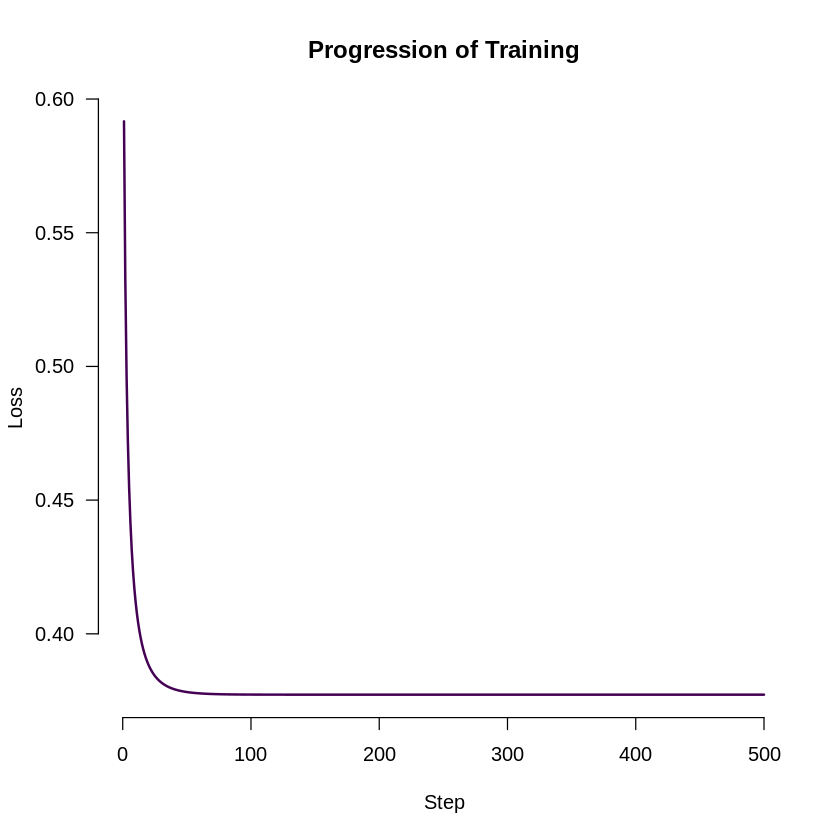

In [103]:
plot(1:n_steps, losses, 
      main = "Progression of Training", xlab = "Step", ylab = "Loss", 
      las = 1, bty = "n",
      type = "l", lwd = 2, col = viridis::viridis(1) )

### Stochastic Gradient Descent

As Machine Learning models are often used with large amounts of data, calculating the gradient over all examples in the training set might become infeasible. 

However, we can use the fact that the gradient is an expectation. This means we can approximate the expectation by taking a random sample from all training examples. Doing this, we introduce a new hyperparameter the size of a batch of training examples $m'$.

Everything else remains as with gradient descent above.

In [104]:
n_steps <- 500
losses <- vector("numeric", length = n_steps)

mb_size <- 64

# Initialize our start point

beta_hat_sgd <- c(0, 0, 0)

for(step in 1:n_steps){
  minibatch_samples <- sample(nrow(train_X), mb_size)
  beta_hat_sgd <- grad_step(beta_hat_sgd, alpha = 1, train_X[minibatch_samples,], train_y[minibatch_samples])

losses[step] <- cost_fct(train_y[minibatch_samples], prediction_fct(train_X[minibatch_samples,], beta_hat_sgd))
}

1,0.02302409
x1,1.98274817
x2,2.00075242


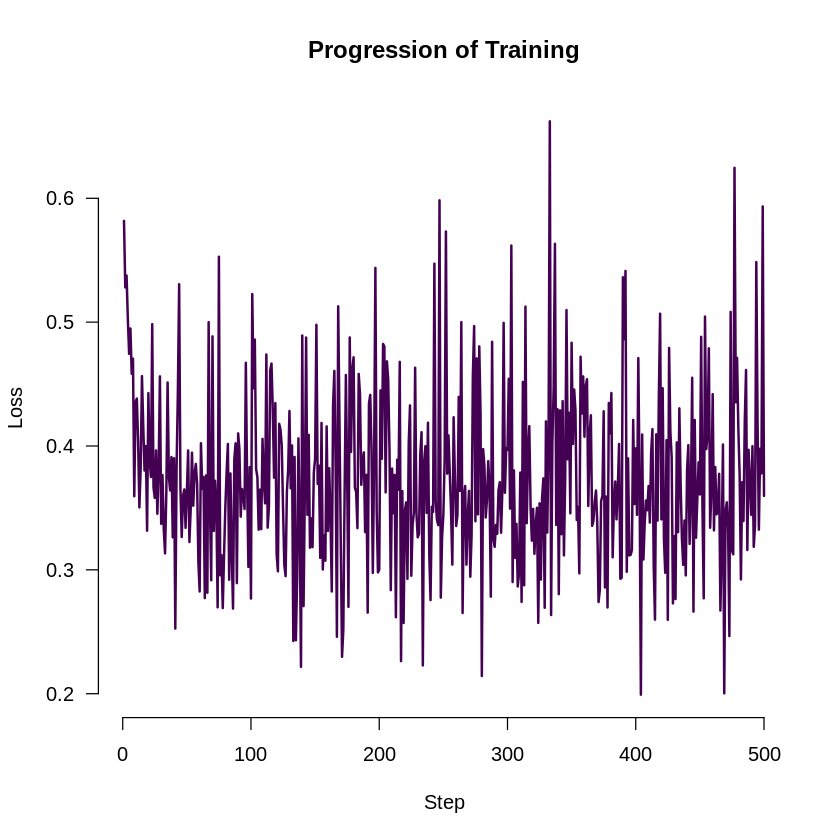

In [105]:
beta_hat

plot(1:n_steps, losses, 
      main = "Progression of Training", xlab = "Step", ylab = "Loss", 
      las = 1, bty = "n",
      type = "l", lwd = 2, col = viridis::viridis(1) )

### Evaluating the Performance

Now we can evaluate the performance of our model using our test set. We calculate predictions of y with the coefficients that we learnt above. For a first overview of the performance we summarize the actual values of y and our predictions in a classification table (also called confusion matrix).

In [110]:
test_X <- as.matrix(cbind(1, test_set[,2:3]))
test_y <- test_set[,1]

predicted_y <- (prediction_fct(test_X, beta_hat) > 0.5) * 1

table(actual = test_y, predicted = predicted_y)

      predicted
actual   0   1
     0 864 164
     1 145 827

Based on the classification table/confusion matrix we could calculate many different performance measures. If you read papers that use Machine Learning you might have heard of some of these measures.

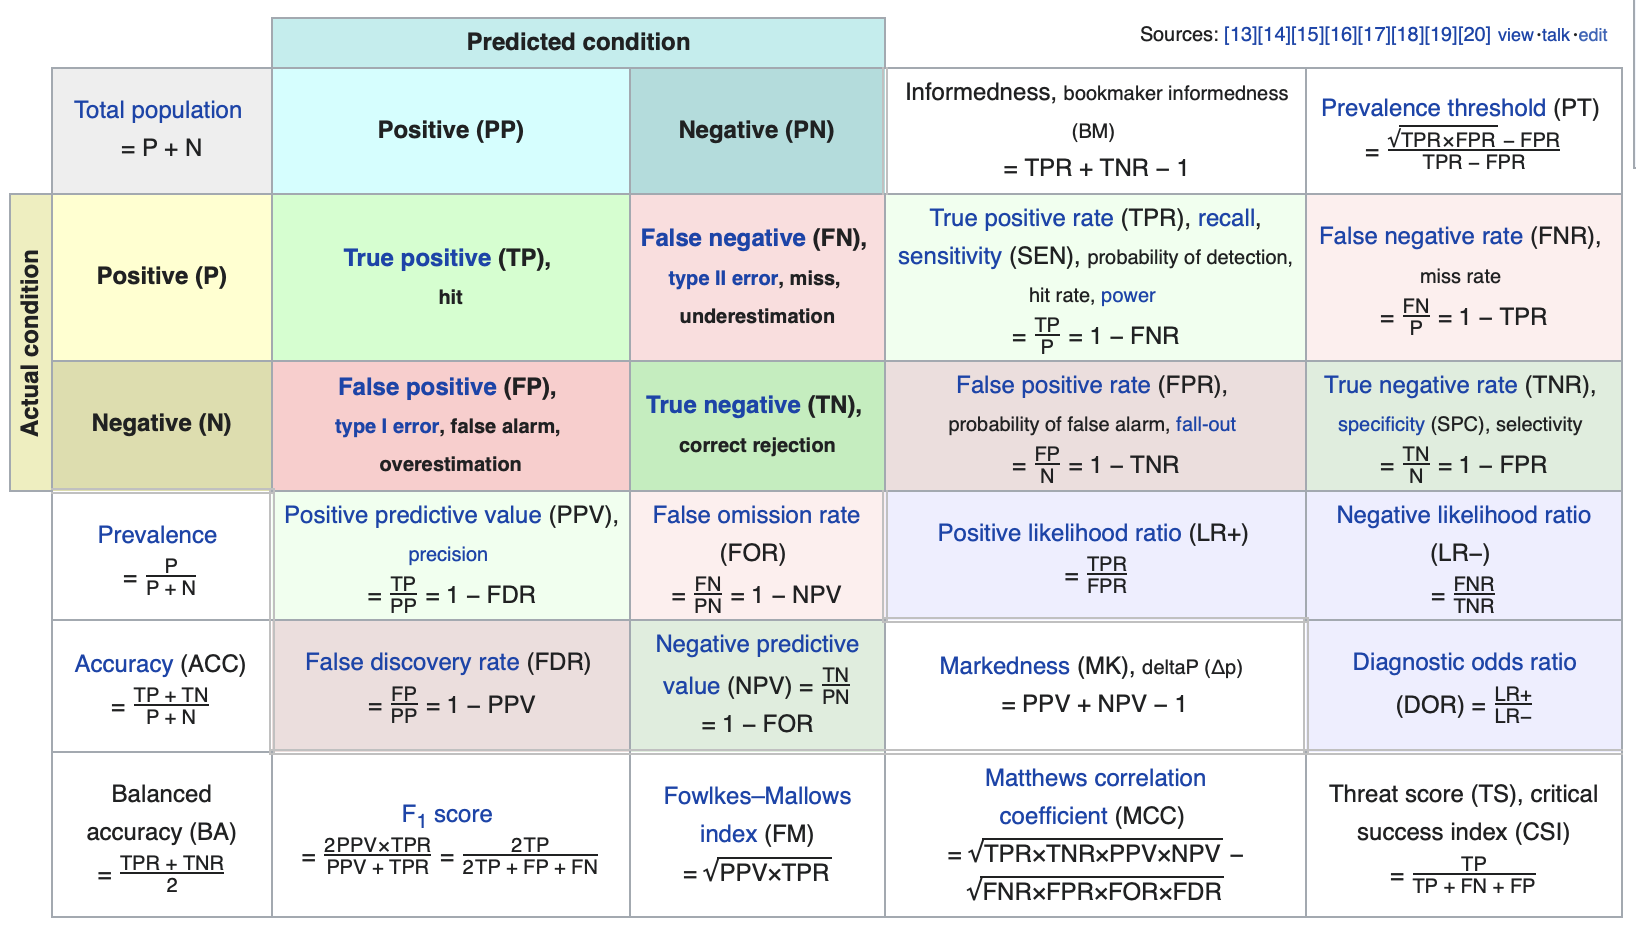

Source: https://en.wikipedia.org/wiki/Confusion_matrix